In [1]:
import sys

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import importlib
from scipy.io import FortranFile

import time 
import cftime 

# import modules in other directories
sys.path.append('../Utils/')
import GridUtils as GrU
import MakePressures as MkP
import humiditycalcs as hum
import MyConstants as Con

sys.path.append('../Regridder/')
import Initialize as Init
import ReadInSrc as RdSrc
import WriteDST as WrDst
import GenRegrid as GR
from GlobalVarClass import Gv


importlib.reload( GR )
#importlib.reload( Gv ) # doesn't work
importlib.reload( Init )
importlib.reload( RdSrc )
importlib.reload( WrDst )


Using Flexible parallel/serial VertRegrid 
Using Flexible parallel/serial VertRegrid 


<module 'WriteDST' from '/glade/work/juliob/PyRegridding/Drivers/../Regridder/WriteDST.py'>

## START HERE FOR "BATCH"

In [ ]:
RegridMethod="CONSERVE" 
foo = Init.prep(Dst='fv1x1',DstVgrid='L32',Src='ERA5',WOsrf=True, RegridMethod=RegridMethod )

In [ ]:
faa =RdSrc.get_Src( year=2021,month=6,day=1 , hour0=99)

In [ ]:
fii=GR.xRegrid(HorzInterpLnPs=False)

In [ ]:
origF='/glade/p/cesm/amwg_dev/juliob/ERA5/ERA5_0.9x1.25_L32.cam2.i.2021-06-01-*.nc'
dsOrig = xr.open_mfdataset( origF,decode_times=False )

In [ ]:
print(list(dsOrig.variables))

#fuu=WrDst.write_netcdf()
te_Orig=dsOrig['T'].values
u_Orig=dsOrig['U'].values
print(np.shape(te_Orig))

In [ ]:
print(Gv.dstTZHkey)

In [ ]:
te_Diff = Gv.te_ERA_xzCAM[0,:,:,:] - te_Orig[0,:,:,:]
u_Diff  = Gv.u_ERA_xzCAM[0,:,:,:] - u_Orig[0,:,:,:]
nt,nz,ny,nx=np.shape( Gv.te_ERA_xzCAM )
te_rms = np.zeros(nz)
u_rms = np.zeros(nz)
plvs = np.zeros( nz )
for z in np.arange( nz ):
    te_rms[z] = np.sum( te_Diff[z,:,:]**2 * Gv.area_CAM )/np.sum( Gv.area_CAM )
    u_rms[z]  = np.sum( u_Diff[z,:,:]**2 * Gv.area_CAM )/np.sum( Gv.area_CAM )
    plvs[z] = np.sum( Gv.pmid_CAM[0,z,:,:] * Gv.area_CAM )/np.sum( Gv.area_CAM )

In [ ]:
clev=np.linspace(200,330,num=31)
#clev=np.linspace(200,290,num=31)
dlev=np.linspace(-5,5,num=21)
#clev=np.linspace(-50,100,num=21)
#clev=np.linspace(277,287,num=31)
#ERA - 89 128
#CAM -124 72
print(Gv.lon_ERA[128], Gv.lat_ERA[89])

# Global
elon,wlon=0,360
slat,nlat=-90,90

# Tibet ...
#elon,wlon=70,100
#slat,nlat=25,40

# Andes ...
#elon,wlon=280,300
#slat,nlat=-40,-10

# Himalayan Front
#elon,wlon=85,95
#slat,nlat=25,28


kCAM=31
nCAM=0

fig,ax = plt.subplots(2,2,figsize=(18,18) ,squeeze=False )

i,j=0,0
cf = ax[i,j].contourf( Gv.lon_CAM, Gv.lat_CAM, Gv.te_ERA_xzCAM[nCAM,kCAM,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp on xzCAM grid from this Python code")
plt.colorbar(cf,ax=ax[i,j] )

i,j=0,1
cf = ax[i,j].contourf( Gv.lon_CAM, Gv.lat_CAM, te_Orig[nCAM,kCAM,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("Temp from Original Code")
plt.colorbar(cf,ax=ax[i,j] )

i,j=1,0
cf = ax[i,j].contourf( Gv.lon_CAM, Gv.lat_CAM, te_Diff[kCAM,:,:],levels=dlev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("Temp from Original Code")
plt.colorbar(cf,ax=ax[i,j] )

i,j=1,1
ax[i,j].plot( te_rms , plvs, label="T" ) #, label='Temp')
ax[i,j].plot( u_rms , plvs, label="U (ms$^{-1}$)")
ax[i,j].legend(loc="upper right")
ax[i,j].set_xlim(0.,0.01)
ax[i,j].set_ylim(100_000.,0.)

po=ax[i,j].set_title("RMS diffs from Original Code")
#po=ax[i,j].legend("upper right")






(100000.0, 0.0)

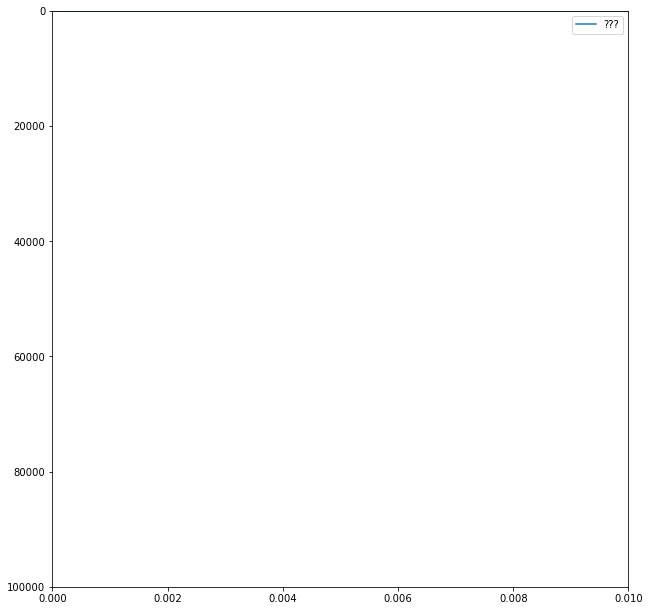

In [5]:
fig = plt.figure(figsize=(8,8))

#ax = fig.add_axes([0.05,0.45,0.4,0.5])
ax = fig.add_axes([0.0,0.0,1,1])


ax.plot(np.arange(0,20,1), np.arange(0,20,1), label='???')
#ax.plot( te_rms , plvs, label="Tooo" ) #, label='Temp')
#ax.plot( u_rms , plvs, label='U')
ax.legend(loc="upper right")
ax.set_xlim(0.,0.01)
ax.set_ylim(100_000.,0.)

In [ ]:
#fuu=GR.write_netcdf(version='test02-oldtopo')

In [ ]:
# Let's look at some interensitng points here
#
location="Sahara"

if (location=="Himalayas"):
    #Himalayan peaks
    Plat,Plon = 36.,76.
    ylim=(60_000.,42_000.)
    xlim=(240,270 )

if (location=="Sahara"):
    #Bordj Badji Mokhtar Algeria
    Plat,Plon = 23.9,-1.8
    ylim=(100_000.,70_000.)
    xlim=(300,320 )

if (location=="Sonora"):
    #Caborca
    Plat,Plon = 30.7,-112.1
    ylim=(100_000.,70_000.)
    xlim=(290,305 )


if (location=="Andes"):
    #Andean peaks
    Plat,Plon=-30.,290.
    ylim=(85_000.,60_000.)
    xlim=(250,300 )

if (location=="SEPac"):
    #
    Plat,Plon=-30.,250.
    ylim=(100_000.,60_000.)
    xlim=(250,300 )

if (location=="Australia"):
    #Australia desert (Alice Springs)
    Plat,Plon=-23.4,135.
    ylim=(96_000.,85_000.)
    xlim=(280,320 )

if (Plon<0.):
    Plon=Plon+360.
    
if (Gv.dstTZHkey=='tzyx'):
    iCAM=np.argmin( np.abs( Gv.lon_CAM - Plon ))
    jCAM=np.argmin( np.abs( Gv.lat_CAM - Plat ))
if (Gv.dstTZHkey=='tzc'):
    cCAM=np.argmin( np.sqrt(  (Gv.lon_CAM - Plon)**2 +  (Gv.lat_CAM - Plat)**2      )      )

iERA=np.argmin( np.abs( Gv.lon_ERA - Plon ))
jERA=np.argmin( np.abs( Gv.lat_ERA - Plat ))
#print(cCAM)
#print(Gv.lon_CAM[cCAM],Gv.lat_CAM[cCAM])
#plt.plot(Gv.lon_ERA)

In [ ]:
#print(te_ERA_xzCAM[nCAM,kCAM,ilat,ilon] )

"""
plt.plot( te_ERA_xCAM [nCAM,:, jCAM, iCAM] , pmid_CAM_zERA [nCAM,:, jCAM, iCAM], '-x' 
         , label='ERA Temp from Python code on xCAM and zERA' )


plt.plot( te_ERA_xzCAM [nCAM,:, jCAM, iCAM], pmid_CAM [nCAM,:, jCAM, iCAM], '-^' 
         , label='ERA Temp from Python code on xzCAM' )
"""
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

for ntime in np.arange(start=0,stop=24,step=6):
    if (ntime==0):
        label1='ERA Temps'
        label2='ERA Temps on xzCAM'
        label3='ERA Temps on xCAM zERA no W&O'
        label4='ERA Temps on xCAM zERA after W&O'
    else:
        label1=None
        label2=None
        label3=None
        label4=None
        

    plt.plot( Gv.te_ERA_xzCAM [ntime,:, jCAM,iCAM] , Gv.pmid_CAM [ntime,:, jCAM,iCAM], 'o-', color='orange'
            , label=label2 )


for ntime in np.arange(4):
    if (ntime==0):
        label1='Original Code'
        label2='ERA Temps on xzCAM'
        label3='ERA Temps on xCAM zERA no W&O'
    else:
        label1=None
        label2=None
        label3=None
        
    plt.plot( te_Orig [ntime,:, jCAM,iCAM] , Gv.pmid_CAM [ntime,:, jCAM,iCAM], '^--',color='cyan'
            , label=label1 )

        
plt.ylim( ylim )
plt.xlim( xlim )
plt.legend(loc='upper left')



plt.subplot(1,2,2)

for ntime in np.arange(start=0,stop=24,step=1):
    if (ntime==0):
        label1='ERA Temps'
        label2='ERA Temps on xzCAM'
        label3='ERA Temps on xCAM zERA no W&O'
        label4='ERA Temps on xCAM zERA after W&O'
    else:
        label1=None
        label2=None
        label3=None
        label4=None
        
    #plt.plot( Gv.te_ERA [ntime,:, jERA, iERA] , Gv.pmid_ERA [ntime,:, jERA, iERA], color='red'
    #        , label=label1 )

    plt.plot( Gv.te_ERA_xzCAM [ntime,:, jCAM,iCAM] , Gv.pmid_CAM [ntime,:, jCAM,iCAM], 'o-',color='orange'
            , label=label2 )

    plt.plot( Gv.te_ERA_xCAM_00 [ntime,:, jCAM,iCAM] , Gv.pmid_CAM_zERA [ntime,:, jCAM,iCAM], color='green'
            , label=label3 )

    plt.plot( Gv.te_ERA_xCAM [ntime,:, jCAM,iCAM] , Gv.pmid_CAM_zERA [ntime,:, jCAM,iCAM], color='blue' 
           , label=label4 )

for ntime in np.arange(4):
    if (ntime==0):
        label1='Original Code'
        label2='ERA Temps on xzCAM'
        label3='ERA Temps on xCAM zERA no W&O'
    else:
        label1=None
        label2=None
        label3=None
        
    plt.plot( te_Orig [ntime,:, jCAM,iCAM] , Gv.pmid_CAM [ntime,:, jCAM,iCAM], '^--',color='cyan'
            , label=label1 )

        
plt.ylim( ylim )
plt.xlim( xlim )
#plt.ylim( 103_000.,90_000.)
#plt.xlim( 285.,295. )


plt.legend(loc='upper left')

In [ ]:
print(np.shape(Gv.pmid_CAM_zERA))#_zERA))
plt.plot(Gv.pmid_CAM_zERA[0,:,20000])

In [ ]:
clev=np.linspace(200,330,num=31)
#clev=np.linspace(200,290,num=31)
dlev=np.linspace(-10,10,num=21)
#clev=np.linspace(277,287,num=31)
#ERA - 89 128
#CAM -124 72
print(Gv.lon_ERA[128], Gv.lat_ERA[89])

# Global
elon,wlon=0,360
slat,nlat=-90,90

# Tibet ...
#elon,wlon=70,100
#slat,nlat=25,40

# Andes ...
#elon,wlon=280,300
#slat,nlat=-40,-10

# Himalayan Front
#elon,wlon=85,95
#slat,nlat=25,28


kCAM=57
kERA=136
kCAM=10
kERA=136
nCAM=0

fig,ax = plt.subplots(2,2,figsize=(18,18) ,squeeze=False )

i,j=0,0
cf = ax[i,j].contourf( Gv.lon_CAM, Gv.lat_CAM, Gv.te_ERA_xCAM[nCAM,kERA,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp on xzCAM grid from Python code")
plt.colorbar(cf,ax=ax[i,j] )

i,j=1,1
cf = ax[i,j].contourf( Gv.lon_ERA, Gv.lat_ERA, Gv.te_ERA[nCAM,kERA,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp on ERA xz grid")
plt.colorbar(cf,ax=ax[i,j] )

i,j=1,0
cf = ax[i,j].contourf( Gv.lon_CAM, Gv.lat_CAM, Gv.te_ERA_xCAM_00[nCAM,kERA,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp on xCAM zERA grid before W&O")
plt.colorbar(cf,ax=ax[i,j] )

i,j=0,1
cf = ax[i,j].contourf( Gv.lon_CAM, Gv.lat_CAM, Gv.te_ERA_xCAM[nCAM,kERA,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp on xCAM zERA grid after W&O")
plt.colorbar(cf,ax=ax[i,j] )


In [ ]:
clev=np.linspace(200,330,num=31)
dlev=np.linspace(-10,10,num=21)
#clev=np.linspace(277,287,num=31)
#ERA - 89 128
#CAM -124 72
print(Gv.lon_ERA[128], Gv.lat_ERA[89])

# Global
elon,wlon=0,360
slat,nlat=-90,90

# Tibet ...
#elon,wlon=70,100
#slat,nlat=25,40

# Andes ...
#elon,wlon=280,300
#slat,nlat=-40,-10

# Himalayan Front
#elon,wlon=85,95
#slat,nlat=25,28


kCAM=57
kERA=136
nCAM=5

fig,ax = plt.subplots(2,2,figsize=(18,18) ,squeeze=False )

i,j=0,0
cf = ax[i,j].contourf( Gv.lon_CAM, Gv.lat_CAM, Gv.te_ERA_xzCAM[nCAM,kCAM,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp on xzCAM grid from Python code")
plt.colorbar(cf,ax=ax[i,j] )

i,j=0,1
cf = ax[i,j].contourf( Gv.lon_CAM, Gv.lat_CAM, Gv.te_ERA_xCAM[nCAM,kERA,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp on xCAM/zERA grid")
plt.colorbar(cf,ax=ax[i,j] )


In [ ]:
print( np.minimum( [0.],[200])[0] )

In [ ]:
Dphis = phis_ERA_xCAM - phis_CAM
plt.plot(Dphis.flatten()-dphis_WO.flatten() )

In [ ]:
file1='/glade/scratch/juliob/ERA5_x_fv1x1_L58_poo4_WO.2017-01-01-18000.nc'
dood=xr.open_dataset( file1 )

## Check Mapping files

In [ ]:


#ERA - 89 128
#CAM -124 72
jCAM,iCAM = 124,72
jERA,iERA = 89,128
nCAM = 3

plt.plot( te_ERA_xCAM [nCAM,:, jCAM, iCAM] , pmid_CAM_zERA [nCAM,:, jCAM, iCAM], '-x' 
         , label='ERA Temp from Python code on xCAM and zERA' )

plt.plot( te_ERA_xCAM_wo2[:, jCAM, iCAM] , press_ERA[:, jCAM, iCAM], '-o' 
         , label='ERA Temp on xCAM and zERA from GUTS OF W&O' )



#plt.plot( te_ERA_xzCAM [0,:,124, 72] , pmid_CAM [0,:,124, 72], '-o' , label='ERA Temp from Python code on xzCAM' )
#plt.plot( te_ERA[0,:,89, 128] ,pmid_ERA [0,:,89, 128] ,'-+', label='ERA Temp at closest xERA point' )


plt.ylim(88_000.,70_000.)
plt.xlim(270,290)
plt.legend()

print(ps_new[jCAM,iCAM])
print(ps_CAM[nCAM,jCAM,iCAM])

print(ps_old[jCAM,iCAM])
print(ps_ERA_xCAM[nCAM,jCAM,iCAM])

